## **Fine-tuning ConvNeXt for TinyImageNet with Self-Attention and Aggressive Regularization (Improvement Model)**

## **Environment & Module Preparation**

In [ ]:
!pip install timm==0.5.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.22
    Uninstalling timm-1.0.22:
      Successfully uninstalled timm-1.0.22


In [ ]:
import os
import time
import shutil
import torch
import timm
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import random


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## **Dataset Preparation**

In [ ]:
os.makedirs("/content/data", exist_ok=True)

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip -d /content/data/

!ls /content/data/tiny-imagenet-200

--2025-12-16 09:39:10--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-12-16 09:39:11--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  14.5MB/s    in 15s     

2025-12-16 09:39:26 (16.1 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [ ]:
val_dir = "/content/data/tiny-imagenet-200/val"
img_dir = os.path.join(val_dir, "images")
annot_file = os.path.join(val_dir, "val_annotations.txt")

with open(annot_file, "r") as f:
    lines = f.readlines()

img_to_class = {}
for line in lines:
    img, cls = line.split("\t")[:2]
    img_to_class[img] = cls

for cls in set(img_to_class.values()):
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

for img, cls in img_to_class.items():
    src = os.path.join(img_dir, img)
    dst = os.path.join(val_dir, cls, img)
    shutil.move(src, dst)

shutil.rmtree(img_dir)
os.remove(annot_file)

In [ ]:
!ls /content/data/tiny-imagenet-200/val | head

n01443537
n01629819
n01641577
n01644900
n01698640
n01742172
n01768244
n01770393
n01774384
n01774750


## **Data Augmentation Transforms**

In [ ]:
train_transform = T.Compose([
    T.Resize((224,224)),
    T.RandAugment(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    T.RandomErasing(p=0.15)
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## **Dataset and DataLoader Setup**

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    root="/content/data/tiny-imagenet-200/train",
    transform=train_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root="/content/data/tiny-imagenet-200/val",
    transform=val_transform
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## **Self-Attention Layer with Dropout**

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim, drop=0.2):
        super().__init__()
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.scale = dim ** -0.5
        self.attn_drop = nn.Dropout(drop)
        self.proj_drop = nn.Dropout(drop)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v
        out = self.proj_drop(out)
        return out

In [ ]:
class ConvNeXtWithSelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "convnext_tiny",
            pretrained=True,
            num_classes=0
        )
        dim = self.backbone.num_features
        self.attn = SelfAttention(dim)
        self.head = nn.Linear(dim, 200)

    def forward(self, x):
        feat = self.backbone(x)
        feat = self.attn(feat.unsqueeze(1)).squeeze(1)
        return self.head(feat)


In [ ]:
model = ConvNeXtWithSelfAttention().to(device)

## **Loss, Optimizer, Scheduler, and Layer Freezing**

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.AdamW(
    [
        {"params": model.backbone.stages[3].parameters(), "lr": 5e-5, "weight_decay": 1e-4},
        {"params": model.attn.parameters(), "lr": 1e-4, "weight_decay": 5e-4},
        {"params": model.head.parameters(), "lr": 3e-4, "weight_decay": 1e-4}
    ]
)


scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50
)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.backbone.stages[3].parameters():
    param.requires_grad = True

for param in model.attn.parameters():
    param.requires_grad = True

for param in model.head.parameters():
    param.requires_grad = True

## **Training**

In [ ]:
def accuracy(out, y):
    return (out.argmax(1) == y).float().mean().item()

patience = 5
best_val = 0
best_epoch = 0
no_improve = 0

train_loss, val_loss = [], []
train_acc, val_acc, lrs = [], [], []
epoch = 0
start = time.time()

while True:
    epoch += 1
    print(f"\n===== Epoch {epoch} =====")

    # TRAIN
    model.train()
    tl, ta = 0, 0

    for x, y in tqdm(train_loader, desc="Train"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        tl += loss.item()
        ta += accuracy(out, y)

    tl /= len(train_loader)
    ta /= len(train_loader)

    # VALIDATION
    model.eval()
    vl, va = 0, 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Val"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            vl += loss.item()
            va += accuracy(out, y)

    vl /= len(val_loader)
    va /= len(val_loader)

    # SCHEDULER
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    # LOGGING
    train_loss.append(tl)
    val_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    lrs.append(lr)

    print(f"\nEpoch {epoch:>2}")
    print("-" * 40)
    print(
    f"{'Train Loss':<11}: {tl:>7.4f} | "
    f"{'Val Loss':<9}: {vl:>7.4f}"
    )
    print(
    f"{'Train Acc':<11}: {ta*100:>6.2f}% | "
    f"{'Val Acc':<9}: {va*100:>6.2f}%"
    )
    print("-" * 40)


    # EARLY STOPPING
    if va > best_val:
        best_val = va
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), "best_convnext_tiny.pth")
        print(f"Best model saved (epoch {epoch})")
    else:
        no_improve += 1
        print(f"No improvement ({no_improve}/{patience})")

    if no_improve >= patience:
        print("Early stopping triggered")
        break



===== Epoch 1 =====


Val: 100%|██████████| 313/313 [00:13<00:00, 23.06it/s]



Epoch  1
----------------------------------------
Train Loss :  2.3775 | Val Loss :  1.1309
Train Acc  :  57.48% | Val Acc  :  84.45%
----------------------------------------
Best model saved (epoch 1)

===== Epoch 2 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.68it/s]



Epoch  2
----------------------------------------
Train Loss :  1.9205 | Val Loss :  1.0691
Train Acc  :  66.28% | Val Acc  :  85.53%
----------------------------------------
Best model saved (epoch 2)

===== Epoch 3 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.64it/s]



Epoch  3
----------------------------------------
Train Loss :  1.8310 | Val Loss :  1.0440
Train Acc  :  68.81% | Val Acc  :  85.93%
----------------------------------------
Best model saved (epoch 3)

===== Epoch 4 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.62it/s]



Epoch  4
----------------------------------------
Train Loss :  1.7731 | Val Loss :  1.0414
Train Acc  :  70.47% | Val Acc  :  85.67%
----------------------------------------
No improvement (1/5)

===== Epoch 5 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.53it/s]



Epoch  5
----------------------------------------
Train Loss :  1.7354 | Val Loss :  1.0304
Train Acc  :  71.56% | Val Acc  :  85.98%
----------------------------------------
Best model saved (epoch 5)

===== Epoch 6 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.60it/s]



Epoch  6
----------------------------------------
Train Loss :  1.7065 | Val Loss :  1.0377
Train Acc  :  72.62% | Val Acc  :  85.94%
----------------------------------------
No improvement (1/5)

===== Epoch 7 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.63it/s]



Epoch  7
----------------------------------------
Train Loss :  1.6590 | Val Loss :  1.0332
Train Acc  :  73.90% | Val Acc  :  86.30%
----------------------------------------
Best model saved (epoch 7)

===== Epoch 8 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.63it/s]



Epoch  8
----------------------------------------
Train Loss :  1.6352 | Val Loss :  1.0403
Train Acc  :  74.59% | Val Acc  :  85.90%
----------------------------------------
No improvement (1/5)

===== Epoch 9 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.57it/s]



Epoch  9
----------------------------------------
Train Loss :  1.6212 | Val Loss :  1.0406
Train Acc  :  75.20% | Val Acc  :  85.90%
----------------------------------------
No improvement (2/5)

===== Epoch 10 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.51it/s]



Epoch 10
----------------------------------------
Train Loss :  1.5985 | Val Loss :  1.0554
Train Acc  :  75.82% | Val Acc  :  85.80%
----------------------------------------
No improvement (3/5)

===== Epoch 11 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.56it/s]



Epoch 11
----------------------------------------
Train Loss :  1.5957 | Val Loss :  1.0574
Train Acc  :  76.03% | Val Acc  :  85.88%
----------------------------------------
No improvement (4/5)

===== Epoch 12 =====


Val: 100%|██████████| 313/313 [00:11<00:00, 27.30it/s]


Epoch 12
----------------------------------------
Train Loss :  1.5795 | Val Loss :  1.0623
Train Acc  :  76.49% | Val Acc  :  85.80%
----------------------------------------
No improvement (5/5)
Early stopping triggered


## **Training Summary**

In [ ]:
total_time = (time.time() - start) / 60
avg_epoch_time = total_time / epoch

print("\n===== TRAINING SUMMARY =====")
print(f"Best Val Accuracy : {best_val*100:.2f}%")
print(f"Best Epoch        : {best_epoch}")
print(f"Total Epochs      : {epoch}")
print(f"Total Time        : {total_time:.2f} minutes")
print(f"Avg Time / Epoch  : {avg_epoch_time:.2f} minutes")


===== TRAINING SUMMARY =====
Best Val Accuracy : 86.30%
Best Epoch        : 7
Total Epochs      : 12
Total Time        : 52.17 minutes
Avg Time / Epoch  : 4.35 minutes


## **Training and Validation Curves Visualization**

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

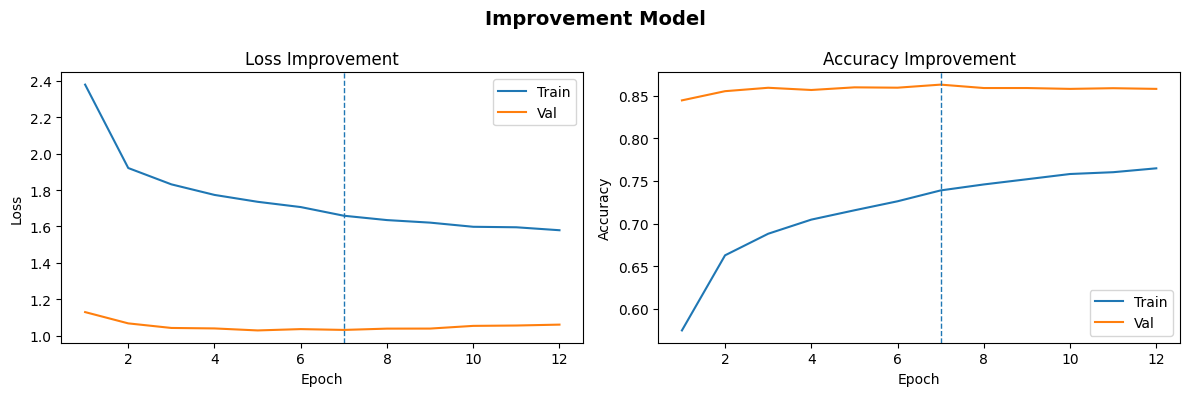

In [ ]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12,4))

# LOSS
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Val")
plt.axvline(best_epoch, linestyle="--", linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Improvement")
plt.legend()

# ACCURACY
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.axvline(best_epoch, linestyle="--", linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Improvement")
plt.legend()

plt.suptitle("Improvement Model", fontsize=14, fontweight="bold")
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, "training_curve.png"), dpi=300)
plt.show()
plt.close()

## **Evaluation with Val Data**

In [ ]:
model.load_state_dict(torch.load("best_convnext_tiny.pth"))
model.eval()

correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

final_acc = 100 * correct / total
print(f"Final Validation Accuracy (Best Model): {final_acc:.2f}%")

Final Validation Accuracy (Best Model): 86.31%


## **Validation Inference with Best Model**

In [ ]:
model.load_state_dict(torch.load("best_convnext_tiny.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

## **Create Validation Results DataFrame**

In [ ]:
df_results = pd.DataFrame({
    "Ground_Truth": all_labels,
    "Prediction": all_preds
})

df_results["Is_Correct"] = df_results["Ground_Truth"] == df_results["Prediction"]

print("Contoh 10 Hasil Prediksi:")
print(df_results.head(10))

Contoh 10 Hasil Prediksi:
   Ground_Truth  Prediction  Is_Correct
0             0           0        True
1             0           0        True
2             0           0        True
3             0           0        True
4             0           0        True
5             0           0        True
6             0           0        True
7             0           0        True
8             0           0        True
9             0           0        True


## **Top & Bottom 5 Classes by Accuracy**

In [ ]:
class_stats = (
    df_results
    .groupby("Ground_Truth")
    .agg(
        Accuracy=("Is_Correct", "mean"),
        Num_Samples=("Is_Correct", "count")
    )
    .sort_values("Accuracy")
)

class_stats["Accuracy (%)"] = class_stats["Accuracy"] * 100
class_stats = class_stats.drop(columns="Accuracy")

print("\n5 Kelas dengan Akurasi Terendah:")
display(class_stats.head(5))

print("\n5 Kelas dengan Akurasi Tertinggi")
display(class_stats.tail(5))


5 Kelas dengan Akurasi Terendah:


,Num_Samples,Accuracy (%)
Ground_Truth,,
159,50,56.0
131,50,60.0
132,50,60.0
32,50,62.0
198,50,66.0



5 Kelas dengan Akurasi Tertinggi


,Num_Samples,Accuracy (%)
Ground_Truth,,
0,50,98.0
25,50,98.0
23,50,98.0
58,50,98.0
145,50,100.0


## **Per-Class Prediction Visualization (Class 0-15)**

In [ ]:
num_classes_to_show = 16
class_indices = defaultdict(list)

for idx, (_, label) in enumerate(val_dataset):
    class_indices[label].append(idx)

selected_indices = [
    random.choice(class_indices[c]) for c in range(num_classes_to_show)
]

images = torch.stack([val_dataset[i][0] for i in selected_indices])
labels = torch.tensor([val_dataset[i][1] for i in selected_indices])

images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)


In [ ]:
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

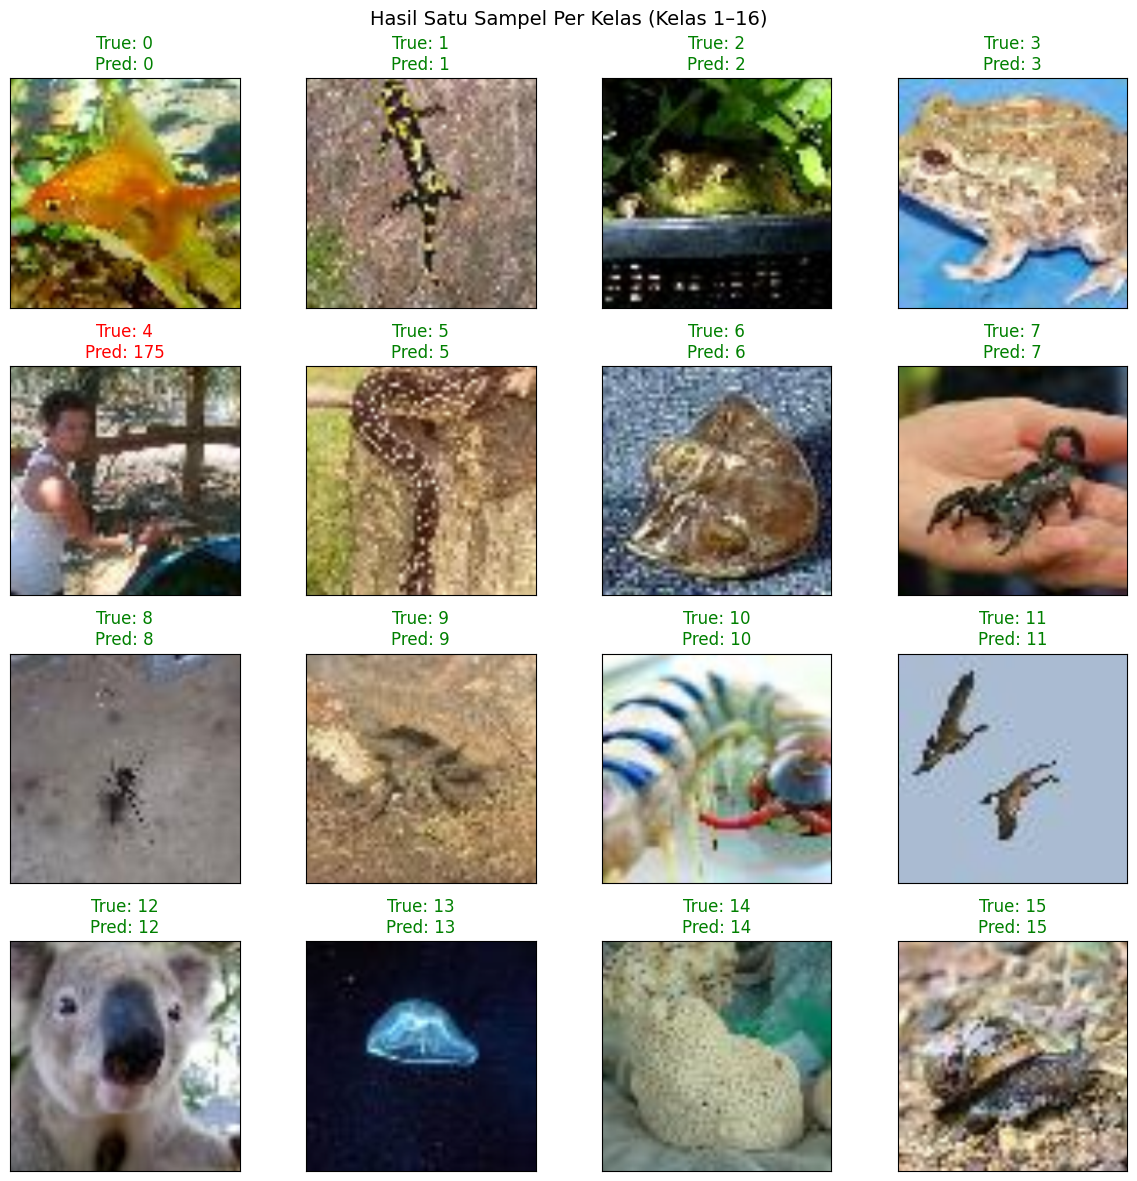

In [ ]:
fig = plt.figure(figsize=(12, 12))

for idx in range(num_classes_to_show):
    ax = fig.add_subplot(4, 4, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])

    pred_idx = preds[idx].item()
    true_idx = labels[idx].item()
    color = "green" if pred_idx == true_idx else "red"
    ax.set_title(f"True: {true_idx}\nPred: {pred_idx}", color=color)

plt.suptitle("Hasil Satu Sampel Per Kelas (Kelas 1–16)", fontsize=14)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, "one_sample_per_class.png"), dpi=300)
plt.show()
plt.close()

## **Visualization of Correct vs Incorrect Predictions**

In [ ]:
df_results = pd.DataFrame({
    "Index": range(len(all_labels)),
    "Ground_Truth": all_labels,
    "Prediction": all_preds
})

df_results["Is_Correct"] = (
    df_results["Ground_Truth"] == df_results["Prediction"]
)

correct_samples = df_results[df_results["Is_Correct"]].sample(8, random_state=42)
wrong_samples = df_results[~df_results["Is_Correct"]].sample(8, random_state=42)

viz_samples = pd.concat([correct_samples, wrong_samples])


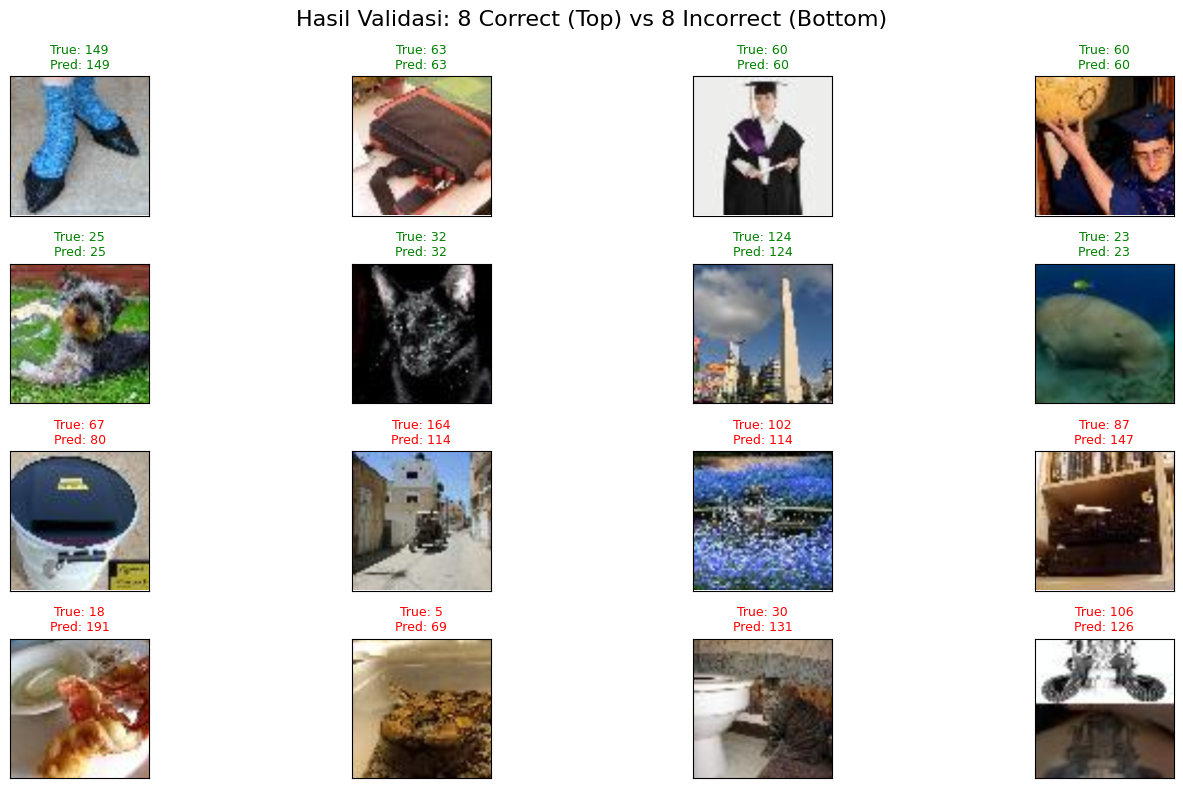

In [ ]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle(
    "Hasil Validasi: 8 Correct (Top) vs 8 Incorrect (Bottom)",
    fontsize=16
)

for i, row in enumerate(viz_samples.itertuples()):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])

    img_tensor, _ = val_dataset[row.Index]
    img = img_tensor.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    color = "green" if row.Is_Correct else "red"
    ax.set_title(
        f"True: {row.Ground_Truth}\nPred: {row.Prediction}",
        color=color,
        fontsize=9
    )

plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, "correct_vs_wrong.png"), dpi=300)
plt.show()
plt.close()

##

## **Save Validation Predictions to CSV**

In [ ]:
df_results.to_csv(
    os.path.join(OUTPUT_DIR, "validation_predictions.csv"),
    index=False
)